# Visualize pymoo result
Load the pymoo result object saved with pickle and visualize it.

ONOSControllerPlacement needs to be definded to load the result object.
So, execute the following cell first.

In [1]:
#!/usr/bin/env python
import numpy as np
import networkx as nx
import math
import pickle
from pymoo.core.problem import ElementwiseProblem

class ONOSControllerPlacement(ElementwiseProblem):
    def __init__(self, num_nodes, distance_matrix, shortest_paths, graph, **kwargs):
        super().__init__(n_var=2*num_nodes, 
                         n_obj=4, 
                         n_constr=2, 
                         xl=0, xu=1, 
                         **kwargs)
        self.num_nodes = num_nodes
        self.distance_matrix = distance_matrix
        self.shortest_paths = shortest_paths
        self.graph = graph
    
    def _evaluate(self, x, out, *args, **kwargs):
        controller_nodes = x[:self.num_nodes]   # first half is controller placement
        atomix_nodes = x[self.num_nodes:]       # second half is atomix placement


        num_controller = np.sum(controller_nodes)
        num_atomix = np.sum(atomix_nodes)

        # Obj1: Minimize number of contrtoller
        f1 = num_controller

        # Obj2: Minimize number of atomix
        f2 = num_atomix

        # Obj: Minimize average FSP
        f3 = calculate_FST(self.num_nodes, 
                           controller_nodes, 
                           atomix_nodes, 
                           self.distance_matrix, 
                           self.shortest_paths)
        
        f4 = calculate_BC(self.num_nodes, 
                           controller_nodes, 
                           atomix_nodes, 
                           self.distance_matrix, 
                        #    self.shortest_paths,
                           self.graph)

        # Constr1: The number of controller is equal to or greater than 2
        g1 = 2 - num_controller

        # Constr2: The number of atomix is equal to or greater than 3
        g2 = 3 - num_atomix
        
        # Add the centrality metrix into optimazing objectives:
        # 1. Nearest controller for each switch
        # 2. The number of controlled switches for each controller should be <= limit_num_switches_controlled (limit_num_switches_controlled=int(math.ceil(num_nodes/num_controller)))
        # 3. return value should be the variance for all controller's betweenness centrality
        out["F"] = [f1, f2, f3, f4]
        out["G"] = [g1, g2]


def calculate_FST(num_nodes, controller_nodes, atomix_nodes, distance_matrix, shortest_paths):
    num_controller = np.sum(controller_nodes)
    num_atomix = np.sum(atomix_nodes)
    controller_list = np.nonzero(controller_nodes)[0].tolist()
    atomix_list = np.nonzero(atomix_nodes)[0].tolist()

    if(num_controller == 0 or num_atomix ==0):
        return math.inf

    # find the nearest controller for each switch
    controller_of = []
    for s in range(num_nodes):
        delay = math.inf
        nearest_controller = None
        for c in controller_list:
            if distance_matrix[s][c] < delay:
                delay = distance_matrix[s][c]
                nearest_controller = c
        controller_of.append(nearest_controller)    

    # calculate average delay to atomix nodes from each controller
    average_atomix_delay_from = {}
    for c in controller_list:
        delay = []
        for a in atomix_list:
            delay.append(distance_matrix[c][a])
        average_atomix_delay_from[c] = np.mean(delay)

    # find the nearest atomix for each atomix and calculate average delay
    atomix_atomix_delays = []
    for a1 in atomix_list:
        delay = math.inf
        for a2 in atomix_list:
            if(a1 == a2):
                continue
            if distance_matrix[a1][a2] < delay:
                delay = distance_matrix[a1][a2]
        atomix_atomix_delays.append(delay)
    average_atomix_atomix_delay = np.mean(atomix_atomix_delays)
    FTSs = []
    for source in range(num_nodes):
        for distination in range(num_nodes):
            if(source == distination):
                continue
            delay = 0
            is_controlled_by_single_controller = True
            counted_controllers = []
            for s in shortest_paths[source][distination]:
                # switch-controller delay
                delay += distance_matrix[s][controller_of[s]] * 4

                # controller-atomix delay
                if(s == source):
                    delay += average_atomix_delay_from[controller_of[s]] * 2
                elif(s != distination):
                    if(controller_of[s] != controller_of[source]):
                        is_controlled_by_single_controller = False
                        if(not controller_of[s] in counted_controllers):
                            counted_controllers.append(controller_of[s])
                            delay += average_atomix_delay_from[controller_of[s]]
                else:
                    if(controller_of[s] == controller_of[source]):
                        if(not is_controlled_by_single_controller):
                            delay += average_atomix_delay_from[controller_of[s]]
                    else:
                        delay += average_atomix_delay_from[controller_of[s]] * 2
            
            # atomix-atomix delay
            delay +=  average_atomix_atomix_delay * 2
            FTSs.append(delay)

    return np.mean(FTSs)



def calculate_BC(num_nodes, controller_nodes, atomix_nodes, distance_matrix, graph):
    G = nx.Graph()
    for node1 in range(len(graph)):
        G.add_node(str(node1))
        for node2, delay in graph[node1].items():
            G.add_edge(str(node1), str(node2), weight=delay)
    
    # The list of betweenness centrality for all switches
    nodes_bc=nx.current_flow_betweenness_centrality(G, normalized=True, weight=None, dtype='float', solver='full')
    num_controller = np.sum(controller_nodes)
    num_atomix = np.sum(atomix_nodes)
    controller_list = np.nonzero(controller_nodes)[0].tolist()

    if(num_controller == 0 or num_atomix ==0):
        return math.inf

    # find the nearest controller for each switch
    controller_of = []
    limit_num_switches_controlled=int(math.ceil(num_nodes/num_controller)) # balance the number of switches controllers can control 
    switches_bc_of_controller_ = dict.fromkeys((range(num_nodes)),0) # list of sum of betweenness centrality of switches for each controller
    for s in range(num_nodes):
        delay = math.inf
        nearest_controller = None
        controlled_switches=[]
        for c in controller_list:
            # Conditions: nearest controller (with the lowest delay) && the number of switches for each controller < limit_num_switches_controlled
            if distance_matrix[s][c] < delay and controller_of.count(c) < limit_num_switches_controlled:
                delay = distance_matrix[s][c]
                nearest_controller = c
                controlled_switches.append(s)
        switches_bc_of_controller_[nearest_controller] += nodes_bc[str(s)]
        controller_of.append(nearest_controller)
    
    # Simplify switches_bc_of_controller_ (only need value for calculating variance)
    bc_array = []
    for i in switches_bc_of_controller_.values():
        bc_array.append(i)

    # return variance value can show the degree of balance within all controllers
    return np.var(bc_array)

### Load Internode results for all algos

In [2]:
with open('res_bc_Internode_agemoea.pkl','rb') as f_agemoea:
    res_agemoea = pickle.load(f_agemoea)
with open('res_bc_Internode_agemoea2.pkl','rb') as f_agemoea2:
    res_agemoea2 = pickle.load(f_agemoea2)
with open('res_bc_Internode_nsga2.pkl','rb') as f_nsga2:
    res_nsga2 = pickle.load(f_nsga2)
with open('res_bc_Internode_nsga3.pkl','rb') as f_nsga3:
    res_nsga3 = pickle.load(f_nsga3)
with open('res_bc_Internode_rnsga2.pkl','rb') as f_rnsga2:
    res_rnsga2 = pickle.load(f_rnsga2)
with open('res_bc_Internode_rnsga3.pkl','rb') as f_rnsga3:
    res_rnsga3 = pickle.load(f_rnsga3)
with open('res_bc_Internode_rvea.pkl','rb') as f_rvea:
    res_rvea = pickle.load(f_rvea)
with open('res_bc_Internode_smsemoa.pkl','rb') as f_smsemoa:
    res_smsemoa = pickle.load(f_smsemoa)
with open('res_bc_Internode_unsga3.pkl','rb') as f_unsga3:
    res_unsga3 = pickle.load(f_unsga3)
with open('res_bc_Internode_ctaea.pkl','rb') as f_ctaea:
    res_ctaea = pickle.load(f_ctaea)
with open('res_bc_Internode_dnsga2.pkl','rb') as f_dnsga2:
    res_dnsga2 = pickle.load(f_dnsga2)
with open('res_bc_Internode_kgbdmoea.pkl','rb') as f_kgbdmoea:
    res_kgbdmoea = pickle.load(f_kgbdmoea)
with open('res_bc_Internode_moead.pkl','rb') as f_moead:
    res_moead = pickle.load(f_moead)

## Hypervolume
1. Store values

In [3]:
# Internode
F_agemoea=res_agemoea.F
F_agemoea2=res_agemoea2.F
F_nsga2=res_nsga2.F
F_nsga3=res_nsga3.F
F_rnsga2=res_rnsga2.F
F_rnsga3=res_rnsga3.F
F_rvea=res_rvea.F
F_smsemoa=res_smsemoa.F
F_unsga3=res_unsga3.F
F_ctaea=res_ctaea.F
F_dnsga2=res_dnsga2.F
F_kgbdmoea=res_kgbdmoea.F
F_moead=res_moead.F

ref_point = [181, 77, 3922.81875, 1.70537209]
# agemoea
# agemoea2
# nsga2
# nsga3
# rnsga2
# rnsga3
# rvea
# smsemoa
# unsga3
# ctaea
# dnsga2
# kgbdmoea
# moead

hist_F_agemoea = []
hist_F_agemoea2 = []
hist_F_nsga2 = []
hist_F_nsga3 = []
hist_F_rnsga2 = []
hist_F_rnsga3 = []
hist_F_rvea = []
hist_F_smsemoa = []
hist_F_unsga3 = []
hist_F_ctaea = []
hist_F_dnsga2 = []
hist_F_kgbdmoea = []
hist_F_moead = []

for agemoea in res_agemoea.history:
    opt_agemoea = agemoea.opt
    feas_agemoea = np.where(opt_agemoea.get("feasible"))[0]
    hist_F_agemoea.append(opt_agemoea.get("F")[feas_agemoea])
for agemoea2 in res_agemoea2.history:
    opt_agemoea2 = agemoea2.opt
    feas_agemoea2 = np.where(opt_agemoea2.get("feasible"))[0]
    hist_F_agemoea2.append(opt_agemoea2.get("F")[feas_agemoea2])
for nsga2 in res_nsga2.history:
    opt_nsga2 = nsga2.opt
    feas_nsga2 = np.where(opt_nsga2.get("feasible"))[0]
    hist_F_nsga2.append(opt_nsga2.get("F")[feas_nsga2])
for nsga3 in res_nsga3.history:
    opt_nsga3 = nsga3.opt
    feas_nsga3 = np.where(opt_nsga3.get("feasible"))[0]
    hist_F_nsga3.append(opt_nsga3.get("F")[feas_nsga3])
for rnsga2 in res_rnsga2.history:
    opt_rnsga2 = rnsga2.opt
    feas_rnsga2 = np.where(opt_rnsga2.get("feasible"))[0]
    hist_F_rnsga2.append(opt_rnsga2.get("F")[feas_rnsga2])
for rnsga3 in res_rnsga3.history:
    opt_rnsga3 = rnsga3.opt
    feas_rnsga3 = np.where(opt_rnsga3.get("feasible"))[0]
    hist_F_rnsga3.append(opt_rnsga3.get("F")[feas_rnsga3])
for rvea in res_rvea.history:
    opt_rvea = rvea.opt
    feas_rvea = np.where(opt_rvea.get("feasible"))[0]
    hist_F_rvea.append(opt_rvea.get("F")[feas_rvea])
for smsemoa in res_smsemoa.history:
    opt_smsemoa = smsemoa.opt
    feas_smsemoa = np.where(opt_smsemoa.get("feasible"))[0]
    hist_F_smsemoa.append(opt_smsemoa.get("F")[feas_smsemoa])
for unsga3 in res_unsga3.history:
    opt_unsga3 = unsga3.opt
    feas_unsga3 = np.where(opt_unsga3.get("feasible"))[0]
    hist_F_unsga3.append(opt_unsga3.get("F")[feas_unsga3])
for ctaea in res_ctaea.history:
    opt_ctaea = ctaea.opt
    feas_ctaea = np.where(opt_ctaea.get("feasible"))[0]
    hist_F_ctaea.append(opt_ctaea.get("F")[feas_ctaea])
for dnsga2 in res_dnsga2.history:
    opt_dnsga2 = dnsga2.opt
    feas_dnsga2 = np.where(opt_dnsga2.get("feasible"))[0]
    hist_F_dnsga2.append(opt_dnsga2.get("F")[feas_dnsga2])
for kgbdmoea in res_kgbdmoea.history:
    opt_kgbdmoea = kgbdmoea.opt
    feas_kgbdmoea = np.where(opt_kgbdmoea.get("feasible"))[0]
    hist_F_kgbdmoea.append(opt_kgbdmoea.get("F")[feas_kgbdmoea])
for moead in res_moead.history:
    opt_moead = moead.opt
    feas_moead = np.where(opt_moead.get("feasible"))[0]
    hist_F_moead.append(opt_moead.get("F")[feas_moead])

2. Calculate hypervolume for each algorithm

In [4]:
from pymoo.indicators.hv import Hypervolume

metric = Hypervolume(ref_point= np.array(ref_point))

hv_agemoea = [metric.do(_F_agemoea) for _F_agemoea in hist_F_agemoea]
hv_agemoea2 = [metric.do(_F_agemoea2) for _F_agemoea2 in hist_F_agemoea2]
hv_nsga2 = [metric.do(_F_nsga2) for _F_nsga2 in hist_F_nsga2]
hv_nsga3 = [metric.do(_F_nsga3) for _F_nsga3 in hist_F_nsga3]
hv_rnsga2 = [metric.do(_F_rnsga2) for _F_rnsga2 in hist_F_rnsga2]
hv_rnsga3 = [metric.do(_F_rnsga3) for _F_rnsga3 in hist_F_rnsga3]
hv_rvea = [metric.do(_F_rvea) for _F_rvea in hist_F_rvea]
hv_smsemoa = [metric.do(_F_smsemoa) for _F_smsemoa in hist_F_smsemoa]
hv_unsga3 = [metric.do(_F_unsga3) for _F_unsga3 in hist_F_unsga3]
hv_ctaea = [metric.do(_F_ctaea) for _F_ctaea in hist_F_ctaea]
hv_dnsga2 = [metric.do(_F_dnsga2) for _F_dnsga2 in hist_F_dnsga2]
hv_kgbdmoea = [metric.do(_F_kgbdmoea) for _F_kgbdmoea in hist_F_kgbdmoea]
hv_moead = [metric.do(_F_moead) for _F_moead in hist_F_moead]

# hv_rnsga3 = [(hv_agemoea + hv_agemoea2 + hv_nsga2 + hv_nsga3 + hv_rnsga2 + hv_rnsga3 + hv_rvea + hv_smsemoa + hv_unsga3 + hv_ctaea + hv_dnsga2 + hv_kgbdmoea + hv_moead) / 13 for hv_agemoea, hv_agemoea2, hv_nsga2, hv_nsga3, hv_rnsga2, hv_rnsga3, hv_rvea, hv_smsemoa, hv_unsga3, hv_ctaea, hv_dnsga2, hv_kgbdmoea, hv_moead in zip(hv_agemoea, hv_agemoea2, hv_nsga2, hv_nsga3, hv_rnsga2, hv_rnsga3, hv_rvea, hv_smsemoa, hv_unsga3, hv_ctaea, hv_dnsga2, hv_kgbdmoea, hv_moead)]

The hypervolumn for agemoea:
[54346234.1087576, 55900088.90213079, 59795556.84407829, 59996262.6046531, 62036672.62933859, 62159043.22323232, 65082550.986007884, 65291316.61272707, 65530564.291031696, 68583095.59919585, 69506043.21700789, 69582185.79322173, 72566074.8884606, 75447633.99078031, 75521063.07882117, 75802203.30336618, 77796499.09552409, 77917935.65676035, 78061232.38921459, 78224416.50832611, 79224452.05516396, 79253414.57213828, 79267701.13863567, 79271990.2407773, 79281900.29346262, 79310250.17552285, 79361068.4219535, 80356736.47902405, 80440366.15903093, 80551225.41679315, 80619190.23506095, 81098671.4282184, 81154922.96187925, 81211348.16522554, 81241778.4995191, 81707575.10750407, 81760428.16281274, 81770180.24708556, 81837849.90922852, 82398763.34054624, 82399312.15854342, 82409754.48071718, 82423405.62555322, 82424941.79209843, 82528979.25464903, 82983564.70172063, 82982670.96496685, 82989654.06701627, 82995059.51549855, 83030652.70328699, 83038233.34609407, 831206

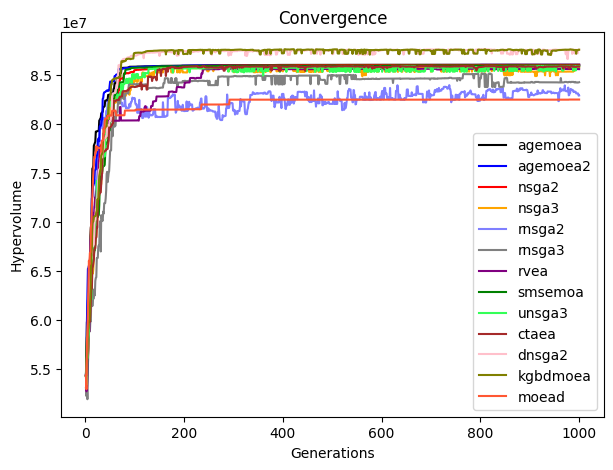

In [5]:
print('The hypervolumn for agemoea:')
print(hv_agemoea)
print('The hypervolumn for agemoea2:')
print(hv_agemoea2)
print('The hypervolumn for nsga2:')
print(hv_nsga2)
print('The hypervolumn for nsga3:')
print(hv_nsga3)
print('The hypervolumn for rnsga2:')
print(hv_rnsga2)
print('The hypervolumn for rnsga3:')
print(hv_rnsga3)
print('The hypervolumn for rvea:')
print(hv_rvea)
print('The hypervolumn for smsemoa:')
print(hv_smsemoa)
print('The hypervolumn for unsga3:')
print(hv_unsga3)
print('The hypervolumn for ctaea:')
print(hv_ctaea)
print('The hypervolumn for dnsga2:')
print(hv_dnsga2)
print('The hypervolumn for kgbdmoea:')
print(hv_kgbdmoea)
print('The hypervolumn for moead:')
print(hv_moead)

# Show all hv for each topo
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.plot(list(range(1, len(hv_agemoea)+1)), hv_agemoea,  color='black', label='agemoea')
plt.plot(list(range(1, len(hv_agemoea2)+1)), hv_agemoea2,  color='blue', label='agemoea2')
plt.plot(list(range(1, len(hv_nsga2)+1)), hv_nsga2,  color='red', label='nsga2')
plt.plot(list(range(1, len(hv_nsga3)+1)), hv_nsga3,  color='orange', label='nsga3')
plt.plot(list(range(1, len(hv_rnsga2)+1)), hv_rnsga2,  color=(0, 0, 1, 0.5), label='rnsga2')
plt.plot(list(range(1, len(hv_rnsga3)+1)), hv_rnsga3,  color='gray', label='rnsga3')
plt.plot(list(range(1, len(hv_rvea)+1)), hv_rvea,  color='purple', label='rvea')
plt.plot(list(range(1, len(hv_smsemoa)+1)), hv_smsemoa,  color='green', label='smsemoa')
plt.plot(list(range(1, len(hv_unsga3)+1)), hv_unsga3,  color='#33FF57', label='unsga3')
plt.plot(list(range(1, len(hv_ctaea)+1)), hv_ctaea,  color='brown', label='ctaea')
plt.plot(list(range(1, len(hv_dnsga2)+1)), hv_dnsga2,  color='pink', label='dnsga2')
plt.plot(list(range(1, len(hv_kgbdmoea)+1)), hv_kgbdmoea,  color='olive', label='kgbdmoea')
plt.plot(list(range(1, len(hv_moead)+1)), hv_moead,  color='#FF5733', label='moead')
plt.title("Convergence")
plt.xlabel("Generations")
plt.ylabel("Hypervolume")
plt.legend()
plt.show()

2. Draw hypervolume for each algorithm

In [6]:
import numpy as np

max_hv_agemoea = np.max(hv_agemoea, axis=0)
max_hv_agemoea2 = np.max(hv_agemoea2, axis=0)
max_hv_nsga2 = np.max(hv_nsga2, axis=0)
max_hv_nsga3 = np.max(hv_nsga3, axis=0)
max_hv_rnsga2 = np.max(hv_rnsga2, axis=0)
max_hv_rnsga3 = np.max(hv_rnsga3, axis=0)
max_hv_rvea = np.max(hv_rvea, axis=0)
max_hv_smsemoa = np.max(hv_smsemoa, axis=0)
max_hv_unsga3 = np.max(hv_unsga3, axis=0)
max_hv_ctaea = np.max(hv_ctaea, axis=0)
max_hv_dnsga2 = np.max(hv_dnsga2, axis=0)
max_hv_kgbdmoea = np.max(hv_kgbdmoea, axis=0)
max_hv_moead = np.max(hv_moead, axis=0)


print('Maximum HV of AGEMOEA: ', + max_hv_agemoea)
print('Maximum HV of AGEMOEA2: ', + max_hv_agemoea2)
print('Maximum HV of NSGA2: ', + max_hv_nsga2)
print('Maximum HV of NSGA3: ', + max_hv_nsga3)
print('Maximum HV of RNSGA2: ', + max_hv_rnsga2)
print('Maximum HV of RNSGA3: ', + max_hv_rnsga3)
print('Maximum HV of RVEA: ', + max_hv_rvea)
print('Maximum HV of SMSEMOA: ', + max_hv_smsemoa)
print('Maximum HV of UNSGA3: ', + max_hv_unsga3)
print('Maximum HV of CTAEA: ', + max_hv_ctaea)
print('Maximum HV of DNSGA2: ', + max_hv_dnsga2)
print('Maximum HV of KGBDMOEA: ', + max_hv_kgbdmoea)
print('Maximum HV of MOEAD: ', + max_hv_moead)

Maximum HV of AGEMOEA:  86055856.94316284
Maximum HV of AGEMOEA2:  86050848.5195399
Maximum HV of NSGA2:  86047338.89614129
Maximum HV of NSGA3:  85904826.26858982
Maximum HV of RNSGA2:  83976622.0099707
Maximum HV of RNSGA3:  85173154.17852993
Maximum HV of RVEA:  85816252.9176301
Maximum HV of SMSEMOA:  86001063.1145549
Maximum HV of UNSGA3:  85904336.29905146
Maximum HV of CTAEA:  85929657.74876645
Maximum HV of DNSGA2:  87642018.69232404
Maximum HV of KGBDMOEA:  87641967.79355091
Maximum HV of MOEAD:  82504867.20033267
